# Tarea 2 - Regresion Polinomial & Feature engineering
### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import sklearn.model_selection as model_selection
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import time

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [3]:
%load_ext tensorboard

In [4]:
data = pd.read_csv('C:\\Users\\eddso\\OneDrive\\Maestría\\Ciclo 2 - 2021\\Statistical Learning\\regresion_polinomial\\winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Variable a predecir: 
12. quality (puntuacion  entre 0 y 10) 


In [5]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Análisis exploratorio

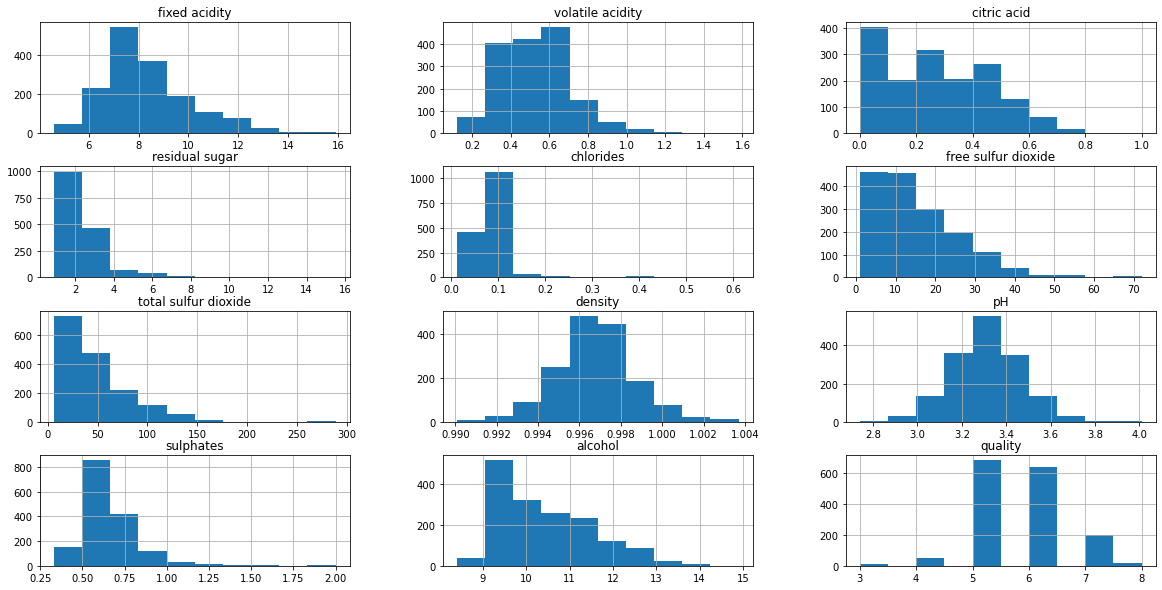

In [6]:
data.hist(figsize = (20,10))
plt.show()

In [7]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
#Correlacion con la variable 'quality'
data.corr()['quality']

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64

#### Selección de features

Se seleccionarán las variables 'alcohol' y 'volatile acidity' por tener mejor correlación con 'quality'.

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

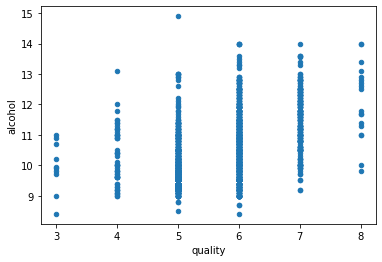

In [9]:
data.plot.scatter(x = 'quality', y = 'alcohol')

<AxesSubplot:xlabel='quality', ylabel='volatile acidity'>

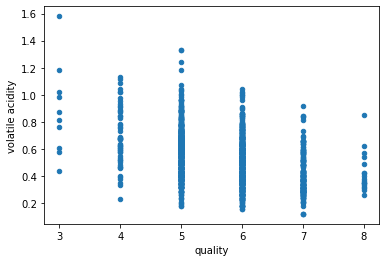

In [10]:
data.plot.scatter(x = 'quality', y = 'volatile acidity')

#### Transformación de features

In [11]:
# Transformacion con polinomio de grado 2
features = np.array(data[['alcohol','volatile acidity']])
polinomioG2 = PolynomialFeatures(2)
trans_featuresG2 = polinomioG2.fit_transform(features)
trans_featuresG2

array([[1.00000e+00, 9.40000e+00, 7.00000e-01, 8.83600e+01, 6.58000e+00,
        4.90000e-01],
       [1.00000e+00, 9.80000e+00, 8.80000e-01, 9.60400e+01, 8.62400e+00,
        7.74400e-01],
       [1.00000e+00, 9.80000e+00, 7.60000e-01, 9.60400e+01, 7.44800e+00,
        5.77600e-01],
       ...,
       [1.00000e+00, 1.10000e+01, 5.10000e-01, 1.21000e+02, 5.61000e+00,
        2.60100e-01],
       [1.00000e+00, 1.02000e+01, 6.45000e-01, 1.04040e+02, 6.57900e+00,
        4.16025e-01],
       [1.00000e+00, 1.10000e+01, 3.10000e-01, 1.21000e+02, 3.41000e+00,
        9.61000e-02]])

In [12]:
# Podemos definir una función para transformar las features al polinomio de n grado
def transformar_features(features, grado):
    poly = PolynomialFeatures(grado)
    return poly.fit_transform(features)

In [13]:
trans_featuresG2 = transformar_features(features,2)
print(trans_featuresG2)
np.shape(trans_featuresG2)

[[1.00000e+00 9.40000e+00 7.00000e-01 8.83600e+01 6.58000e+00 4.90000e-01]
 [1.00000e+00 9.80000e+00 8.80000e-01 9.60400e+01 8.62400e+00 7.74400e-01]
 [1.00000e+00 9.80000e+00 7.60000e-01 9.60400e+01 7.44800e+00 5.77600e-01]
 ...
 [1.00000e+00 1.10000e+01 5.10000e-01 1.21000e+02 5.61000e+00 2.60100e-01]
 [1.00000e+00 1.02000e+01 6.45000e-01 1.04040e+02 6.57900e+00 4.16025e-01]
 [1.00000e+00 1.10000e+01 3.10000e-01 1.21000e+02 3.41000e+00 9.61000e-02]]


(1599, 6)

In [14]:
trans_featuresG3 = transformar_features(features,3)
print(trans_featuresG3)
np.shape(trans_featuresG3)

[[1.00000000e+00 9.40000000e+00 7.00000000e-01 ... 6.18520000e+01
  4.60600000e+00 3.43000000e-01]
 [1.00000000e+00 9.80000000e+00 8.80000000e-01 ... 8.45152000e+01
  7.58912000e+00 6.81472000e-01]
 [1.00000000e+00 9.80000000e+00 7.60000000e-01 ... 7.29904000e+01
  5.66048000e+00 4.38976000e-01]
 ...
 [1.00000000e+00 1.10000000e+01 5.10000000e-01 ... 6.17100000e+01
  2.86110000e+00 1.32651000e-01]
 [1.00000000e+00 1.02000000e+01 6.45000000e-01 ... 6.71058000e+01
  4.24345500e+00 2.68336125e-01]
 [1.00000000e+00 1.10000000e+01 3.10000000e-01 ... 3.75100000e+01
  1.05710000e+00 2.97910000e-02]]


(1599, 10)

### Preparación de los datos

In [72]:
grado = 2
x_data = transformar_features(features,grado)
y_data = np.array(data['quality']).reshape(-1,1)
weight_rows = len(x_data[0])
columns_tensor = len(x_data[1])

### Definición del grafo

In [73]:
tf.reset_default_graph()
gr = tf.Graph()
with gr.as_default():
    tensor_x = tf.placeholder(tf.float32,[None,columns_tensor],"tensor_x")
    tensor_y = tf.placeholder(tf.float32,[None,1],"tensor_y")
    weight = tf.get_variable("peso",dtype=tf.float32,shape=[weight_rows,1],initializer=tf.zeros_initializer())
    learning_rate = tf.placeholder("float", name = "learning_rate")
    bias = tf.get_variable("sesgo",dtype=tf.float32,shape=[],initializer=tf.zeros_initializer())
    epochs = tf.placeholder(tf.int32, name = "epochs")
    batch_size = tf.placeholder(tf.int32, name = "batch_size")
    with tf.name_scope("modelo"):
        y_hat = tf.add(tf.matmul(tensor_x,weight),bias)
    with tf.name_scope("MSE"):
        costo = 1/2*tf.reduce_mean(tf.math.square(y_hat - tensor_y))
        costo_summary = tf.summary.scalar("MSE", costo)
    with tf.name_scope("gradiente"):
        gradiente = tf.gradients(costo, [weight, bias])
    with tf.name_scope("actualizacion_parametros"):
        actualizacion_weight = tf.assign(weight, weight - learning_rate*gradiente[0])
        actualizacion_bias = tf.assign(bias, bias - learning_rate*gradiente[1])
        actualizacion_parametros = tf.group(actualizacion_weight,actualizacion_bias)
    init = tf.global_variables_initializer()

***Grafo en Tensorboard***
<img src="https://github.com/eddson90/tareas_data_science/blob/main/SL_Tarea2_Parte2_Graph.PNG?raw=true">

In [46]:
def entrenar_modelo(x_data, y_data, lr, epoch, b_size):
    total_iteraciones = int(len(x_data)/b_size)
    tf.reset_default_graph()
    
    with tf.Session(graph = gr) as sess:
        timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time()))
        writer = tf.summary.FileWriter('./TB_log_dir/reg_polinomial/'+str(timestamp)+'_lr='+str(lr)+'_b_size='+str(b_size)+'_epoch='+str(epoch)+'_grado='+str(grado),gr)
        sess.run(init)

        for e in range(epoch):

            for i in range(total_iteraciones):
                muestra_inicio = i*b_size
                muestra_fin = muestra_inicio + b_size
                x_mb =  np.array(x_data[muestra_inicio:muestra_fin]).reshape([-1,1])
                y_mb = np.array(y_data[muestra_inicio:muestra_fin]).reshape([-1,1])

                feed_dict2 = {tensor_x :x_data, tensor_y:y_data, learning_rate:lr, epochs:epoch, batch_size:b_size}
                act_p, w, b, c = sess.run([actualizacion_parametros, weight, bias, costo_summary], feed_dict=feed_dict2)
                #print("Epoch {} iteracion {} m={} b={}".format(e,i,w,b))
                writer.add_summary(c, e)

            feed_dict = {tensor_x:np.array(x_data), tensor_y:np.array(y_data)}
            prediccion = sess.run(y_hat, feed_dict = feed_dict)

        final_weight,final_bias = sess.run([weight,bias],feed_dict=feed_dict)
        print("Weight {} | Bias {}".format(final_weight, final_bias))

        writer.close()
        
        return final_weight, final_bias

In [74]:
entrenar_modelo(x_data, y_data, 0.0001, 150, 32)

Weight [[ 0.07526894]
 [ 0.40831083]
 [ 0.01743011]
 [ 0.01114798]
 [-0.01215553]
 [-0.00630338]] | Bias 0.0752689316868782


(array([[ 0.07526894],
        [ 0.40831083],
        [ 0.01743011],
        [ 0.01114798],
        [-0.01215553],
        [-0.00630338]], dtype=float32),
 0.07526893)

In [67]:
%tensorboard --logdir "C:\Users\eddso\OneDrive\Maestría\Tareas Git Hub\tareas_data_science\TB_log_dir\reg_polinomial"

Reusing TensorBoard on port 6006 (pid 14868), started 0:00:48 ago. (Use '!kill 14868' to kill it.)

***Comparativo del MSE por modelo***
<img src="https://github.com/eddson90/tareas_data_science/blob/main/SL_Tarea2_Parte2%20-%20MSE_regresion_polinomial.PNG?raw=true">

El mejor modelo es un polinomio de grado 2 con learning rate de 0.0001 como se muestra en la última línea:

<img src="https://github.com/eddson90/tareas_data_science/blob/main/SL_Tarea2_Parte2%20-%20Resumen%20MSE.PNG?raw=true">